<a href="https://colab.research.google.com/github/tompc35/oceanography-notebooks/blob/master/NDBC_wind_physoce_key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NDBC data - analysis of wind vector time series

This notebook demonstrates common time series analysis techniques with a two-dimensional data set: wind velocity from a meteorological buoy offshore of Monterey Bay. The buoy is maintained by the National Data Buoy Center (NDBC).

The goal of this analysis is to calculate Ekman transport from buoy wind data.

![upwelling_cartoon](https://oceanexplorer.noaa.gov/facts/media/upwelling-800.jpg)






### Load data and packages

#### Data source

The data from Monterey NDBC buoy 46042 can be accessed from two different locations (we will be using the second here):

* [Main page for buoy 46042 with real time data](https://www.ndbc.noaa.gov/station_page.php?station=46042)

![Buoy map](https://www.ndbc.noaa.gov/images/maps/Monterey_Bay.gif)



#### Install Python packages

If working in Google Colab, some packages need to be installed.

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install airsea
    !pip install gsw

  Created wheel for airsea: filename=airsea-0.0.1-py3-none-any.whl size=12495 sha256=018a9d696fbffbb4d72bcdc38f8d39e014b6efb327a66e463ec1e2dc9baa2ea8
  Stored in directory: /root/.cache/pip/wheels/f7/35/0d/4c636c7d278f518075beafc7826c110e65ba37c7671d5a17cb
Successfully built airsea
     |████████████████████████████████| 2.4 MB 34.7 MB/s 


#### Load Python packages

This notebook uses the [xarray](http://xarray.pydata.org/en/stable/index.html) package, which is useful for working with multi-dimensional arrays. We will use xarray to load data in NetCDF format, which is a common data format used for large data sets in the earth sciences (CDF literally stands for "common data format").

This notebook also uses functions specifically developed for oceanographic time series analyis in the [physoce](https://github.com/physoce/physoce-py) package.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from airsea.windstress import stress
import pandas as pd

#### Load wind data

We can use the *Pandas* library to access the data on NDBC's website. The code for converting this file format into a dataframe is provided.

In [5]:
txt_file = 'https://www.ndbc.noaa.gov/data/5day2/46042_5day.txt'

In [6]:
df_raw = pd.read_csv(txt_file,skiprows=[1],sep='\s+',parse_dates=[[0,1,2,3,4]])
df = df_raw.apply(pd.to_numeric,errors='coerce')
df['time'] = pd.to_datetime(df_raw['#YY_MM_DD_hh_mm'],format='%Y %m %d %H %M',errors='coerce')
df = df.set_index('time')

In [7]:
df

,#YY_MM_DD_hh_mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
time,,,,,,,,,,,,,,,
2021-10-26 18:10:00,NaN,100.0,4.0,7.0,NaN,NaN,NaN,NaN,1024.1,13.6,14.9,NaN,NaN,NaN,NaN
2021-10-26 18:00:00,NaN,100.0,4.0,7.0,NaN,NaN,NaN,NaN,1024.1,13.5,14.9,NaN,NaN,NaN,NaN
2021-10-26 17:50:00,NaN,100.0,4.0,6.0,3.8,15.0,9.6,299.0,1024.1,13.4,14.9,NaN,NaN,NaN,NaN
2021-10-26 17:40:00,NaN,100.0,4.0,8.0,NaN,NaN,NaN,NaN,1024.0,13.5,14.9,NaN,NaN,NaN,NaN
2021-10-26 17:30:00,NaN,100.0,4.0,6.0,NaN,NaN,NaN,NaN,1023.9,13.6,14.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21 19:10:00,NaN,180.0,6.0,7.0,NaN,NaN,NaN,NaN,1020.2,15.0,14.2,NaN,NaN,NaN,NaN
2021-10-21 19:00:00,NaN,180.0,6.0,7.0,NaN,NaN,NaN,NaN,1020.3,15.0,14.2,NaN,NaN,NaN,NaN
2021-10-21 18:50:00,NaN,180.0,6.0,7.0,2.3,13.0,8.4,299.0,1020.4,15.0,NaN,NaN,NaN,NaN,NaN


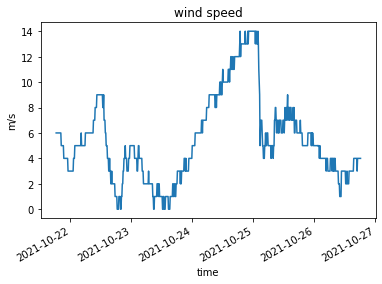

In [12]:
df['WSPD'].plot(title='wind speed',ylabel='m/s')
#plt.ylabel('[m/s]')
#plt.title('wind speed')

##### *Exercises*

* Make a plot for wind *direction*, including title and axis label.
* Make a plot for wave height 

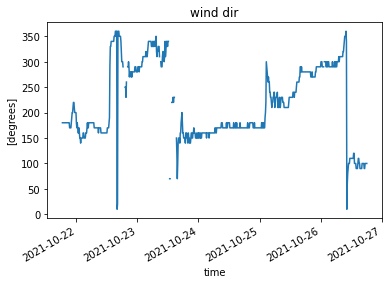

In [43]:
df['WDIR'].plot(title='wind dir',ylabel='[degrees]')

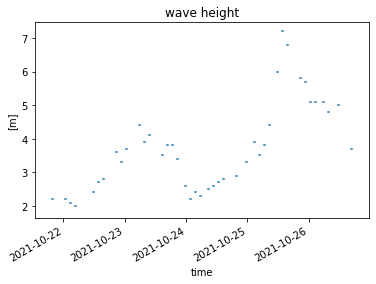

In [44]:
df['WVHT'].plot(title='wave height',ylabel='[m]')

#### Exercise

At noon on 10/24, are the winds favorable for upwelling or downwelling?

Downwelling (be sure to account for the fact that NDBC buoys report the direction that the wind is coming FROM.

### Calculating wind stress

Physical oceanographers are often more interested in the *wind stress* than the wind speed. The wind stress is the force exerted on the surface of the ocean by the wind, and it has units of force per unit area [N/m$^2$] or [Pa]. Stress is typically denoted by the variable $\tau$ (tau). Like wind velocity, wind stress is a vector and has both an eastward component ($\tau^{se}$) and a northward component ($\tau^{sn}$).

The wind stress generally varies as a function of wind speed and the roughness of the sea surface (which also depends on the wind speed). To calculate stress, we need to know the wind velocity, and how high above the sea surface the wind measurements were collected.

According to the [NDBC buoy site](https://www.ndbc.noaa.gov/station_page.php?station=46042), the anemometer that collects the wind observations is positioned at a height 4.1 m above the sea surface.

We can use the `stress` function in the Python [airsea toolbox](https://github.com/pyoceans/python-airsea) to calculate the magnitude of the wind stress from the wind speed and measurement height.

In [17]:
stress?

In [33]:
df['tau'] = stress(df['WSPD'],z=4.1)

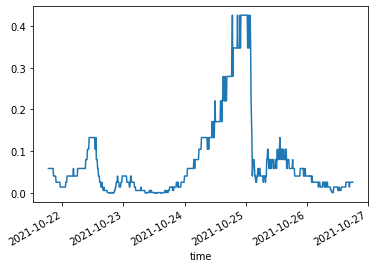

In [34]:
df['tau'].plot()

Use some trig to find the eastward and northward components of stress. The direction of the wind stress is the same as the direction of the wind velocity.

In [31]:
df['tau_east'] = -df['tau']*np.cos((90-df['WDIR'])*np.pi/180)
df['tau_north'] = -df['tau']*np.sin((90-df['WDIR'])*np.pi/180)

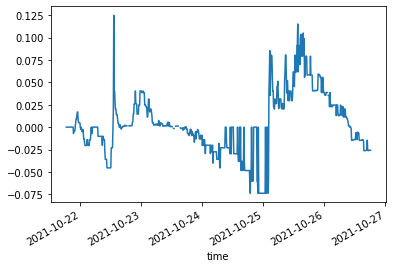

In [40]:
df['tau_east'].plot()

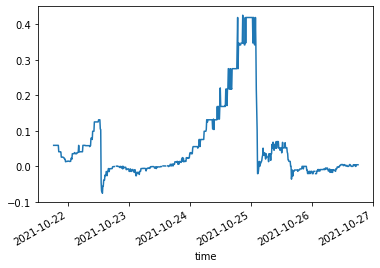

In [41]:
df['tau_north'].plot()

#### Extra Exercises 

Physical oceanography calculations. Compute and plot the eastward Ekman transport $U_{Ek}$ and the northward Ekman transport $V_{Ek}$.

In [ ]:
# insert code here

#### Exercise

Apply this same analysis to another NDBC buoy on the west coast. 

* Find the buoy ID number using the map interface at https://www.ndbc.noaa.gov/
* In the `txt_file` variable above, replace 46042 with the new buoy ID number.

In [161]:
# insert code here